**By:** Reynaldo Ace Bonita Jr. 

# Self-Taught Learning with an Auto-Encoder and a 3 Layer Neural Network

The objectives of this part are:
- train an auto-encoder and combine it with a 3-layer neural network to build an augmented self-taught network by learning from labeled and unlabeled data. 

- compare the performance of a 3-layer neural network and an augment self-taught network

The procedure I followed is as follows:
- read labeled, unlabeled and test CSV files into h2o.
- combine labled and unlabeled data as the training dataset. 
- train an auto-encoder with one hidden layer, varying the number of neurons from 20 to 500
- get the output of the hidden layers and use it as additional feature for the labeled dataset
- feed this data to a 3-layer neural network with 100 units in the hidden layer
- calculate and record the test error
- using the labeled dataset, train a 3-layer NN with 1 hidden layer containing 100 neurons 

My answers to the questions are as follows:

**- What is the relationship of the reconstruction error with the number of units in the auto-encoder's middle layer? (Question 3.III)**

    - The reconstruction error has an inverse relationship with the number of units in the auto-encoder's middle layer. As the number of units in the auto-encoder's middle layer increases, the reconstruction error decreases. The reconstruction error measures how accurately the units in the hidden layer can decode the encoded input. Since the auto-encoder attempts to represent all the features (which in this case, is 783) into the number of units. Understandably, it can do it better if there are more units. However, the graph also shows that the value of an additional unit after a certain count diminishes. Adding units beyond that count add minimal value. 
    
**- What are the optimum numbers of units in the middle layer of the auto-encoder in terms of the reconstruction and misclassification errors? (Question 3.VII)**

    - Looking at the graph of the reconstruction error against the number of units, there is a more significant improvement when the number of units was increased until about 140 units. After that, the improvement in the reconstruction error is marginal. This seem to indicate that the most significant features can be reduced to about 140 units. Adding units beyond that count add minimal value. 
    - Looking at the graph of the misclassification error against the number of units, the optimum number of auto-encoder neurons in the middle layer is 460. It is the point with the lowest classification error in my graph. 

**- What is the relationship between the reconstruction error and the misclassification error? (Question 3.VIII)**

    - The reconstruction error and misclassificaiton error are directly proportional to each other. As the reconstruction error decreases, the misclassification error decreases too. As the reconstruction error decreases, it means that the model improves in decoding the encoded inputs. In other words, the features in hidden layer is enough to represent the data. When the number of hidden layers is sufficient to represent the latent variable, then a classifer performs better when fed this feature set. The misclassification error decreases as the model's performance increases. 

### Loading H2O

In [365]:
##########################
library(h2o)
options(warn=-1)
localH2O =  h2o.init(nthreads = -1, ip='localhost',strict_version_check = FALSE, port = 54321, max_mem_size = '6G', startH2O = TRUE)


 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         21 seconds 989 milliseconds 
    H2O cluster version:        3.24.0.3 
    H2O cluster version age:    19 days  
    H2O cluster name:           developer 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   2.00 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4 
    R Version:                  R version 3.5.1 (2018-07-02) 



### Reading the Data

In [366]:
## Most of the core code I used is taken from the codebase provided. 

# I used the absolute path of the file in my local machine
labeled.frame <- h2o.importFile(path = '/Users/developer/Desktop/FIT5201 Assignment 2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = '/Users/developer/Desktop/FIT5201 Assignment 2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = '/Users/developer/Desktop/FIT5201 Assignment 2/Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [322]:
## Checking if the data was read properly
#head(labeled.frame[1:ncol(labeled.frame),])
#head(unlabeled.frame[1:ncol(unlabeled.frame),])
#tail(train.frame[1:ncol(test.frame),])

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,⋯,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Get a subset for debugging

In [85]:
#dim(labeled.frame)
#dim(unlabeled.frame)
#dim(train.frame)
#dim(test.frame)

labeled.frame.subset <- h2o.splitFrame(data=labeled.frame, ratios=0.50)[[1]]
unlabeled.frame.subset <- h2o.splitFrame(data=unlabeled.frame, ratios=0.20)[[1]]
train.frame.subset <- h2o.splitFrame(data=train.frame, ratios=0.20)[[1]]
test.frame.subset <- h2o.splitFrame(data=test.frame, ratios=0.20)[[1]]


### Computing the classification error

In [ ]:
# Most of the core code I used is taken from the codebase provided. There cited the source: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}


### Initializations

In [356]:
## Epoc setting for all models
local.epoc <- 100

## Sets the number of neuros from 20 to 500 with a step size of 20
H <- seq(20, 500, 20)

## Initializing storage variable for the reconstruction and classification error
error <- data.frame(H,reconstruction.error.test=rep(0, length(H)),
                      classification.error.train=rep(0, length(H)),
                      classification.error.test=rep(0, length(H)))
#error

H,reconstruction.error.test,classification.error.train,classification.error.test
20,0,0,0
40,0,0,0
60,0,0,0
80,0,0,0
100,0,0,0
120,0,0,0
140,0,0,0
160,0,0,0
180,0,0,0
200,0,0,0


### Main Loop

In this loop, I performed the following operations:
- train an auto-encoder with one hidden layer, varying the number of neurons from 20 to 500
- compute the reconstruction error of every model trained
- get the output of the hidden layers and use it as additional feature for the labeled dataset
- feed this data to a 3-layer neural network with 100 units in the hidden layer

In [358]:
for (h in H) {
    
    # Build auto-encoder using unlabeled data
    autoencoder.model <- h2o.deeplearning(    
      x = 2:ncol(train.frame), # select all pixels + extra features
      training_frame = train.frame, # specify the frame (imported file)    
      hidden = c(h), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = TRUE, # is it an autoencoder? Yes!
      l2 = 0.1
    )
      
    # Compute reconstruction error 
    test.anomaly = h2o.anomaly(autoencoder.model, test.frame, per_feature=FALSE)
    reconstruction.test.error <- as.data.frame(test.anomaly)
    error[error$H==h, 'reconstruction.error.test'] <- colMeans(reconstruction.test.error)

    # Get deep features as extra features
    deepfeatures = as.matrix(h2o.deepfeatures(autoencoder.model, labeled.frame, layer=1))
    labeled.frame.with_extra_features <- h2o.cbind(labeled.frame,as.h2o(deepfeatures))

    # Build NN using the data set with original + extra features
    NN.model.with_extra_features <- h2o.deeplearning(    
      x = 2:ncol(labeled.frame.with_extra_features), # select all pixels + extra features
      y = 1,
      training_frame = labeled.frame.with_extra_features, # specify the frame (imported file)    
      hidden = c(100), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )

    # Compute classification error for 1) train and 2) test for the dataset with extra features
    train.predict <- h2o.predict(NN.model.with_extra_features, labeled.frame)$predict
    error[error$H==h, 'classification.error.train'] <- error.rate(labeled.frame$label, train.predict)
    
    test.predict <- h2o.predict(NN.model.with_extra_features, test.frame)$predict
    error[error$H==h, 'classification.error.test']  <- error.rate(test.frame$label, test.predict)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

In [359]:
error

H,reconstruction.error.test,classification.error.train,classification.error.test
20,0.06325184,0.04,0.556
40,0.05308784,0.04,0.524
60,0.04884060,0.06,0.589
80,0.04817830,0.02,0.550
100,0.04865863,0.10,0.554
120,0.04373836,0.06,0.576
140,0.04298547,0.02,0.575
160,0.04212335,0.06,0.601
180,0.04195561,0.10,0.521
200,0.04186716,0.08,0.580


In [362]:
error.backup <- error

I am doing a second run of the remaining neuron counts that haven't finished processing. I kept the loop running for more than 24 hours and it still hasn't finished. There are 3 more remaining iterations

In [ ]:
## Epoc setting for all models
local.epoc <- 100

## Sets the number of neuros from 20 to 500 with a step size of 20
H <- seq(440, 500, 20)

## Initializing storage variable for the reconstruction and classification error
error.2 <- data.frame(H,reconstruction.error.test=rep(0, length(H)),
                      classification.error.train=rep(0, length(H)),
                      classification.error.test=rep(0, length(H)))

In [379]:
for (h in H) {
    
    # Build auto-encoder using unlabeled data
    autoencoder.model <- h2o.deeplearning(    
      x = 2:ncol(train.frame), # select all pixels + extra features
      training_frame = train.frame, # specify the frame (imported file)    
      hidden = c(h), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = TRUE, # is it an autoencoder? Yes!
      l2 = 0.1
    )
      
    # Compute reconstruction error 
    test.anomaly = h2o.anomaly(autoencoder.model, test.frame, per_feature=FALSE)
    reconstruction.test.error <- as.data.frame(test.anomaly)
    error[error$H==h, 'reconstruction.error.test'] <- colMeans(reconstruction.test.error)

    # Get deep features as extra features
    deepfeatures = as.matrix(h2o.deepfeatures(autoencoder.model, labeled.frame, layer=1))
    labeled.frame.with_extra_features <- h2o.cbind(labeled.frame,as.h2o(deepfeatures))

    # Build NN using the data set with original + extra features
    NN.model.with_extra_features <- h2o.deeplearning(    
      x = 2:ncol(labeled.frame.with_extra_features), # select all pixels + extra features
      y = 1,
      training_frame = labeled.frame.with_extra_features, # specify the frame (imported file)    
      hidden = c(100), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )

    # Compute classification error for 1) train and 2) test for the dataset with extra features
    #train.predict <- h2o.predict(NN.model.with_extra_features, labeled.frame)$predict
    #error[error$H==h, 'classification.error.train'] <- error.rate(labeled.frame$label, train.predict)
    
    test.predict <- h2o.predict(NN.model.with_extra_features, test.frame)$predict
    error[error$H==h, 'classification.error.test']  <- error.rate(test.frame$label, test.predict)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

### # Build NN using the original features

This part addresses Question IV. I built a classification model using h2o.deeplearning where autoencoder=FALSE and one hidden layer containing 100 units. The error rate is 0.546. 

In [376]:
NN.model <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), 
  y = 1,
  training_frame = labeled.frame, 
  hidden = c(100), # number of layers and their units
  epochs = local.epoc, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)

  |======================================================================| 100%


In [378]:
test.predict <- h2o.predict(NN.model, test.frame)$predict
nn.model.test.error <- error.rate(test.frame$label, test.predict)
nn.model.test.error

  |======================================================================| 100%


[1] 0.546

### Plots

This section contains the following plots:
- autoencoder reconstruction error for every number of units in the hidden layer
- misclassification error for every number of units in the hidden layer
- misclassification error for 3-layer NN with 1 hidden layer containing 100 units

In [ ]:
library(ggplot2)

Looking at the graph of the reconstruction error against the number of units, there is a more significant improvement when the number of units was increased until about 140 units. After that, the improvement in the reconstruction error is marginal. This seem to indicate that the most significant features can be reduced to about 140 units. Adding units beyond that count add minimal value.

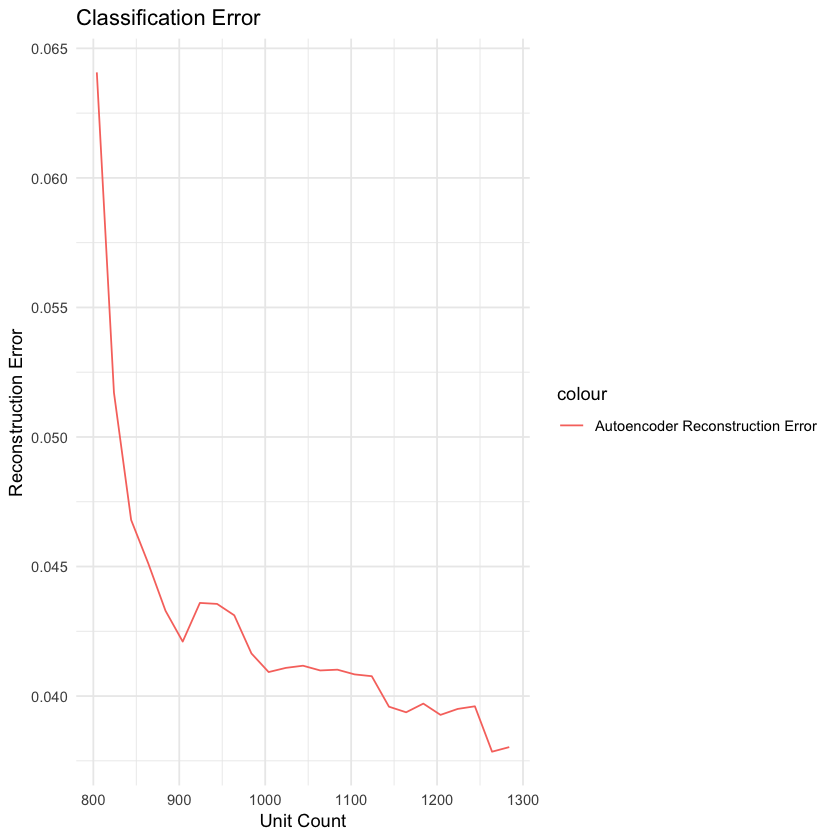

In [380]:
ggplot(error, aes(x=H+ncol(train.frame))) + 
    geom_line(aes(y = reconstruction.error.test, colour = "Autoencoder Reconstruction Error"))+
    ggtitle('Classification Error') +
    xlab("Unit Count") +
    ylab("Reconstruction Error") + theme_minimal()
       

The classification error graph should show that the error goes down as the number of feature increases. It seems reasonable to assume that there might be a certain number of neurons, where after going down, the error starts going back up. However, the classification error that came out of my computation does not reflect this behavior. It seems like there is something amiss in my implementation. The steps I followed are as follows:
- build auto-encoder using labeled and unlabeled data
- use h2o.deepfeatures with the trained auto-encoder and the labeled data to get outputs of hidden layer
- add hidden layers as columns to the labeled dataset 
- use this to train nn (with 100 neurons)
- evaluate trained nn using test data

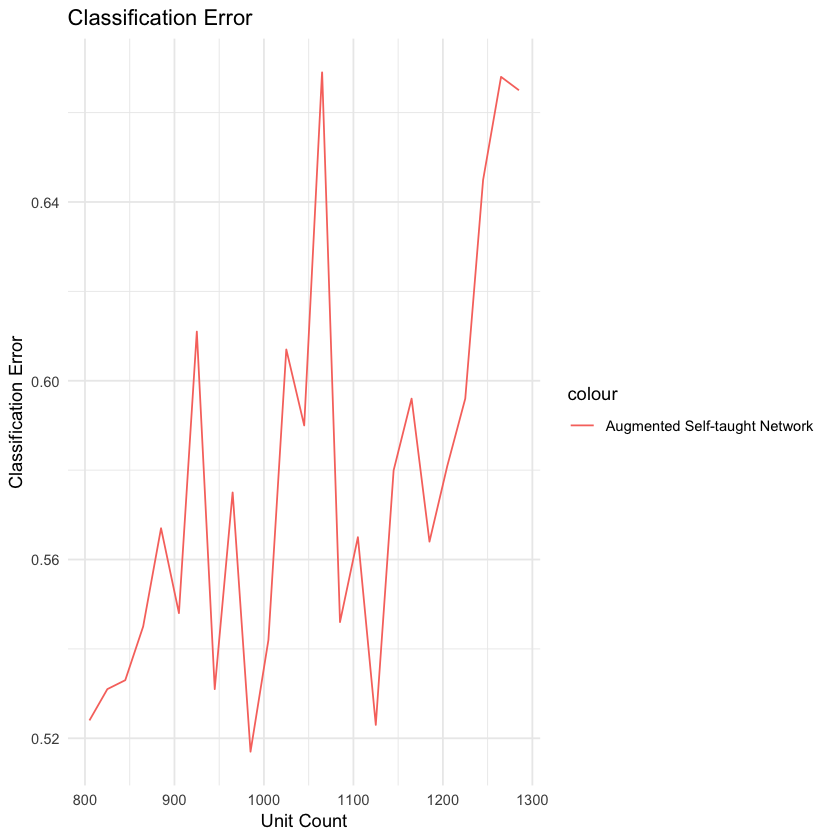

In [388]:
ggplot(error, aes(x=H+ncol(test.frame))) + 
    geom_line(aes(y = classification.error.test, colour = "Augmented Self-taught Network"))+
    ggtitle('Classification Error') +
    xlab("Unit Count") +
    ylab("Classification Error") +
    theme_minimal()


The reconstruction error and misclassificaiton error are directly proportional to each other. As the reconstruction error decreases, the misclassification error decreases too. As the reconstruction error decreases, it means that the model improves in decoding the encoded inputs. In other words, the features in hidden layer is enough to represent the data. When the number of hidden layers is sufficient to represent the latent variable, then a classifer performs better when fed this feature set. The misclassification error decreases as the model's performance increases. 

After reviewing the steps I took, I failed to find anything misplaced. I decided to rerun the computation with a smaller epoc. However, it seems like the classification error still failed to go down as the number of features increased. 

I will, however, still try to use the graph to answer the question regarding the optimum number of auto-encoder neurons in the middle layer is 460. It is the point with the lowest classification error in my graph. 

In [389]:
## Epoc setting for all models
local.epoc <- 50

## Sets the number of neuros from 20 to 500 with a step size of 20
H <- seq(20, 500, 20)

## Initializing storage variable for the reconstruction and classification error
error.v2 <- data.frame(H,reconstruction.error.test=rep(0, length(H)),
                      classification.error.train=rep(0, length(H)),
                      classification.error.test=rep(0, length(H)))

In [390]:
for (h in H) {
    
    # Build auto-encoder using unlabeled data
    autoencoder.model <- h2o.deeplearning(    
      x = 2:ncol(train.frame), # select all pixels + extra features
      training_frame = train.frame, # specify the frame (imported file)    
      hidden = c(h), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = TRUE, # is it an autoencoder? Yes!
      l2 = 0.1
    )
      
    # Compute reconstruction error 
    test.anomaly = h2o.anomaly(autoencoder.model, test.frame, per_feature=FALSE)
    reconstruction.test.error <- as.data.frame(test.anomaly)
    error.v2[error.v2$H==h, 'reconstruction.error.test'] <- colMeans(reconstruction.test.error)

    # Get deep features as extra features
    deepfeatures = as.matrix(h2o.deepfeatures(autoencoder.model, labeled.frame, layer=1))
    labeled.frame.with_extra_features <- h2o.cbind(labeled.frame,as.h2o(deepfeatures))

    # Build NN using the data set with original + extra features
    NN.model.with_extra_features <- h2o.deeplearning(    
      x = 2:ncol(labeled.frame.with_extra_features), # select all pixels + extra features
      y = 1,
      training_frame = labeled.frame.with_extra_features, # specify the frame (imported file)    
      hidden = c(100), # number of layers and their units
      epochs = local.epoc, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )

    # Compute classification error for 1) train and 2) test for the dataset with extra features
    #train.predict <- h2o.predict(NN.model.with_extra_features, labeled.frame)$predict
    #error[error$H==h, 'classification.error.train'] <- error.rate(labeled.frame$label, train.predict)
    
    test.predict <- h2o.predict(NN.model.with_extra_features, test.frame)$predict
    error.v2[error.v2$H==h, 'classification.error.test']  <- error.rate(test.frame$label, test.predict)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

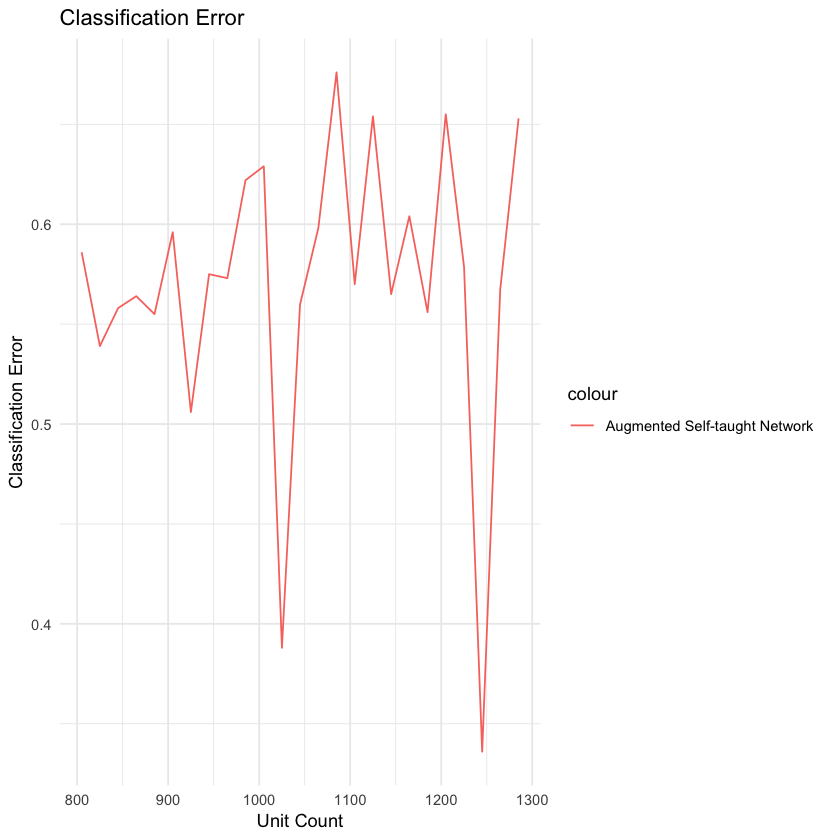

In [392]:
ggplot(error.v2, aes(x=H+ncol(test.frame))) + 
    geom_line(aes(y = classification.error.test, colour = "Augmented Self-taught Network"))+
    ggtitle('Classification Error') +
    xlab("Unit Count") +
    ylab("Classification Error") +
    theme_minimal()


In [394]:
error.v2

H,reconstruction.error.test,classification.error.train,classification.error.test
20,0.06154868,0,0.586
40,0.05012662,0,0.539
60,0.04555043,0,0.558
80,0.04495097,0,0.564
100,0.04489718,0,0.555
120,0.04333969,0,0.596
140,0.04345332,0,0.506
160,0.04301119,0,0.575
180,0.04277435,0,0.573
200,0.04214215,0,0.622
